## Grid Search and Cross Validation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *
DATA_DIR = '../data'

### Data

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

### Train/Test Split

In [9]:
from sklearn.cross_validation import train_test_split

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

### Model

In [7]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X1, y1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [8]:
from sklearn.metrics import accuracy_score

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

### Cross Validation

Train two models, each on different splits of the data. The prediction accuracy will give you a better sense of your model's performance. An example of 5-fold CV:

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-5-fold-CV.png)

* http://scikit-learn.org/stable/modules/cross_validation.html

In [10]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

In [12]:
from sklearn.cross_validation import cross_val_score

# 5-fold CV
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

### Underfitting or Overfitting?

* Underfitting (high bias)
    * Use a more complex model (higher capacity)
    * Add more features 
* Overfitting
    * Use less complex model
    * Get more training data
    * Add regularization (weight decay, data augmentation, dropout)
    * Remove features, simplify features

### Bias Variance Tradeoff

* Bias - How correct your predictions are
    * High bias = underfitting (bad model)
* Variance - How consistent your predictions are (if trained on different subsets)
    * High variance = overfitting (memorizing noise)

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-bias-variance.png)


* For high-bias models (underfit), the performance of the model on the validation set is similar to the performance on the training set. Both are bad.
* For high-variance models (overfit), the performance of the model on the validation set is far worse than the performance on the training set. Train good, validation bad.

### Visualize Training Curve

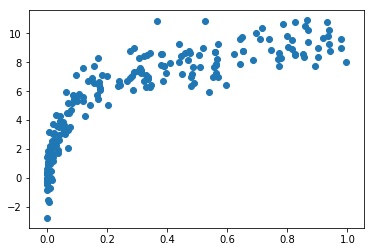

In [14]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

In [16]:
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

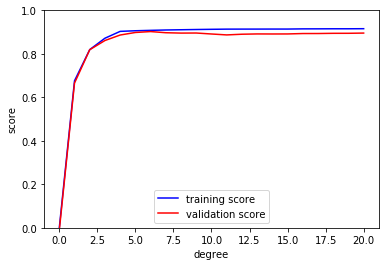

In [18]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

### Plotting Learning Curve

Learning curve will indicate whether we need more data, higher-capacity model, etc

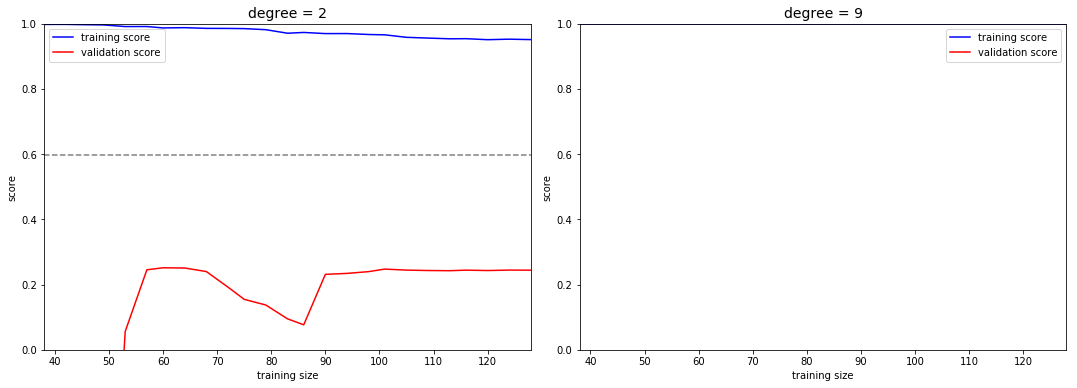

In [19]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data. In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) adding more training data will not significantly improve the fit!

The only way to increase the converged score is to use a different (usually more complicated) model. 

### Grid Search

Here is an example of using grid search to find the optimal polynomial model. 

* http://scikit-learn.org/stable/modules/grid_search.html

In [21]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y);

In [22]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 2}

In [24]:
model = grid.best_estimator_